In [1]:
import torch
import numpy as np
import random

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from ucimlrepo import fetch_ucirepo 

from noise_schedulers import LinearScheduler
from tempering import TemperingLearningRegression
from models import MLP

seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print ("Device: ", device)
print ("Seed: ", seed)

# Set random seed for reproducibility
# This ensures consistent results across different runs
torch.manual_seed(seed)  # Set seed for PyTorch
np.random.seed(seed)     # Set seed for NumPy
random.seed(seed)        # Set seed for Python's random module

Device:  cuda
Seed:  42


In [2]:
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
X = wine_quality.data.features.to_numpy()
y = wine_quality.data.targets.to_numpy()

# train test split
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)

X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# summary of the dataset
print ("X_train shape: ", X_train.shape)
print ("y_train shape: ", y_train.shape)
print ("X_test shape: ", X_test.shape)
print ("y_test shape: ", y_test.shape)

N = X_train.shape[0]

X_train shape:  torch.Size([5197, 11])
y_train shape:  torch.Size([5197, 1])
X_test shape:  torch.Size([1300, 11])
y_test shape:  torch.Size([1300, 1])


In [4]:
n = 0.2
m = 0.5
burn_in_fraction = 0.2
T = 200
MC_steps = 500
lr = 1e-5
zeta = 1.0
tau = 1.0
init_sigma = 0.01

In [5]:
noise_scheudler = LinearScheduler(T=T, init_sigma=init_sigma)
D = noise_scheudler.transform(y_train)
sigmas = noise_scheudler.sigmas
D[-1,:,:]

tensor([[5.],
        [7.],
        [6.],
        ...,
        [5.],
        [5.],
        [5.]], device='cuda:0')

In [6]:
model = MLP(X_train.shape[-1], [16, 16], 1).to(device)
model

MLP(
  (network): Sequential(
    (0): Linear(in_features=11, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [7]:
trainer = TemperingLearningRegression(
    D = D,
    X = X_train,
    model = model,
    sigmas = sigmas,
    tau = tau,
    zeta = zeta,
    init_lr = lr,
    burn_in_fraction=burn_in_fraction,
    MC_steps=MC_steps,
    n = n,
    m = m,
    X_test = X_test,
    y_test = y_test
)

In [8]:
train_loss, test_loss = trainer.train()

100%|██████████| 200/200 [08:38<00:00,  2.59s/it]


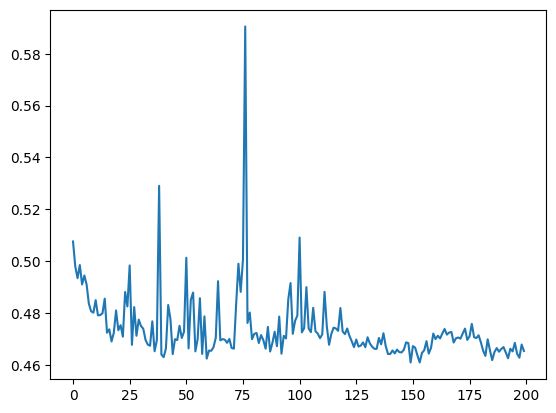

In [9]:
plt.plot(np.arange(len(train_loss)), train_loss, label="Train Loss")

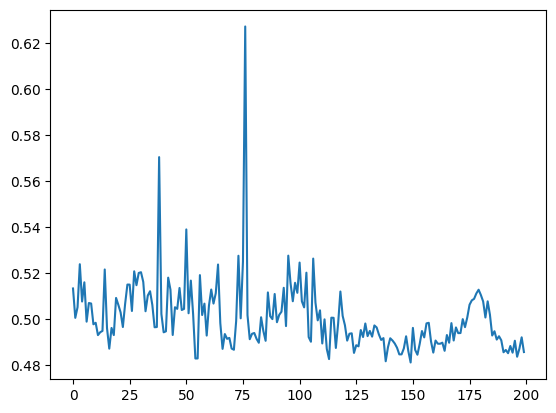

In [10]:
plt.plot(np.arange(len(test_loss)), test_loss, label="Test Loss")